# Import Library

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

# Check Dataset

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Dataset

In [ ]:
# dataset directory
data_path='/content/gdrive/MyDrive/Dataset/FaceRecognition'
os.listdir(data_path)

['gender_classification.csv',
 'class_identity.txt',
 'list_attribute.txt',
 'gender_classification.xlsx',
 'Images']

In [ ]:
image_path = data_path+'/Images'
images_list = os.listdir(image_path)

In [ ]:
# load data
gender_df = pd.read_csv(data_path + '/list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Mapping/change the label to  0 (female) & 1 (male) instead of -1 (female) & 1 (male)
gender_df.replace(-1, 0, inplace=True)

# Reset the index and move it to a new column 'filename'
gender_df.reset_index(level=0, inplace=True)
gender_df.rename(columns={'index': 'filename'}, inplace=True)

gender_df.head(5)

,filename,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0


## Filter Data based on image in folder

In [ ]:
 # filter the data with available images only (5000 images)
filtered_df = gender_df[gender_df.filename.isin(images_list)]
filtered_df

,filename,Male
50,000051.jpg,1
51,000052.jpg,1
64,000065.jpg,1
165,000166.jpg,1
197,000198.jpg,0
...,...,...
202319,202320.jpg,0
202339,202340.jpg,0
202346,202347.jpg,0
202356,202357.jpg,0


In [ ]:
# Change class name
final_df = filtered_df.copy()
# Map the values in the 'Male' column to 'Female' and 'Male'
final_df['Gender'] = final_df['Male'].map({0: 'Female', 1: 'Male'})

# Drop the original 'Male' column
final_df.drop(columns=['Male'], inplace=True)

# Display the updated DataFrame
final_df.head()

,filename,Gender
50,000051.jpg,Male
51,000052.jpg,Male
64,000065.jpg,Male
165,000166.jpg,Male
197,000198.jpg,Female


In [ ]:
final_df.duplicated().value_counts()

False    5000
dtype: int64

## Check Class Label

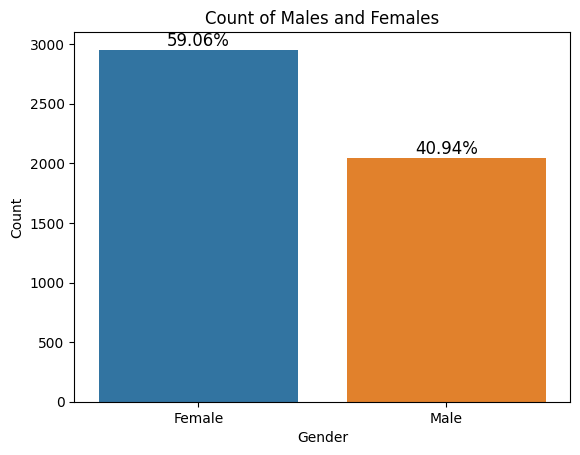

In [ ]:
# Create a new DataFrame to group data by gender and get the count
gender_count = final_df.groupby('Gender')['filename'].count().reset_index(name='count')

# Create the bar graph
ax = sns.barplot(x='Gender', y='count', data=gender_count)

# Calculate the percentages
total_count = gender_count['count'].sum()
for index, row in gender_count.iterrows():
    count = row['count']
    percentage = (count / total_count) * 100
    ax.text(index, count, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)

# Add a title and labels
plt.title('Count of Males and Females')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the graph
plt.show()

## Check image and dimensions

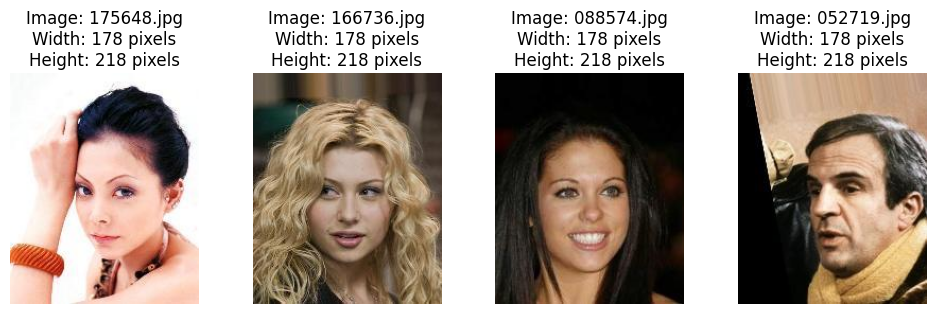

In [ ]:
import matplotlib.pyplot as plt
import random

# Get 4 random image file names
random_images = random.sample(images_list, 4)

# Create a row of subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, image_filename in enumerate(random_images):
    # Open the image
    image = Image.open(data_path + '/Images/' + image_filename)

    # Get the dimensions (size) of the image
    width, height = image.size

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {image_filename}\nWidth: {width} pixels\nHeight: {height} pixels")
    axes[i].axis('off')

# Display the row of images
plt.show()

# Data Preprocessing and Augmentation

## Split dataset into training and test

In [ ]:
# Split the data
train_data, test_data = train_test_split(final_df, test_size=0.2, stratify=final_df['Gender'], random_state=42)

In [ ]:
# Hyperparameter
input_shape   = (224, 224, 3)
image_size    = (224, 224)
batch_size    = 32
num_epochs    = 50
learning_rate = 0.0001

# Create a data generator (for training data)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Rescale on test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=image_path,
    x_col='filename',
    y_col='Gender',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True  # Shuffle the training data
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=image_path,
    x_col='filename',
    y_col='Gender',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False # Don't shuffle the val data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=image_path,
    x_col='filename',
    y_col='Gender',
    target_size=image_size,
    batch_size=batch_size,
    class_mode= 'binary',
    shuffle=False  # Don't shuffle the test data
)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


## Explore some training data

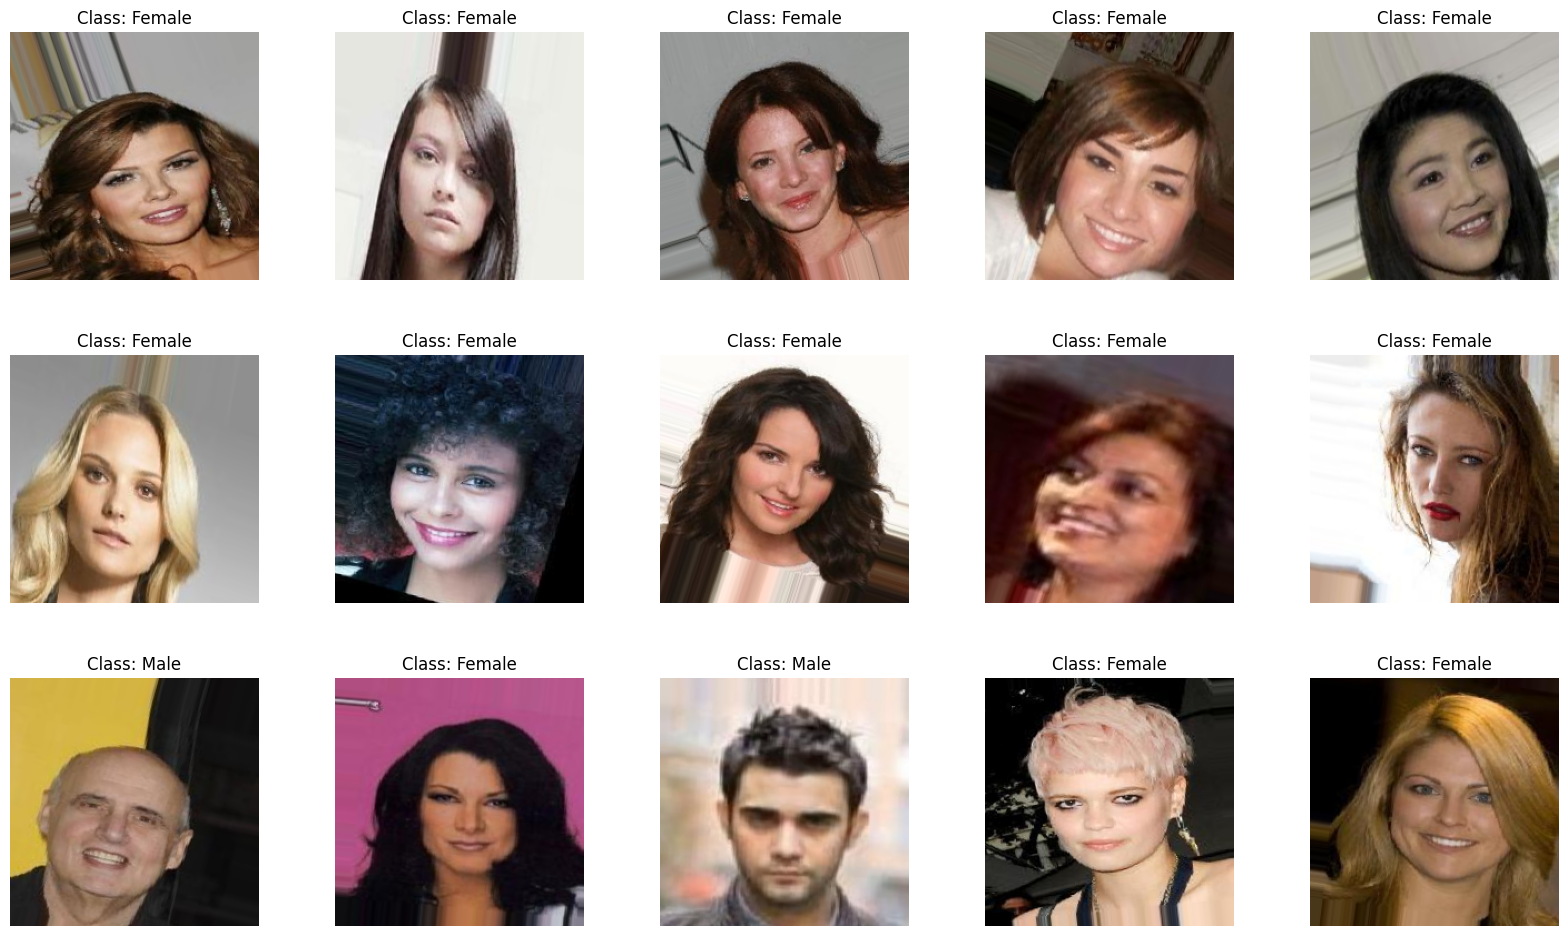

In [ ]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[(titles[i].astype(int))]}')
    plt.axis("off")

# Model Building

In [ ]:
def resnet50_model():
    # Load the pre-trained ResNet-50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom classification layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    for layer in base_model.layers:
        layer.trainable = True

    return model

In [ ]:
#get model
model = resnet50_model()
#compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
#model summary
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24112513 (91.98 MB)
Trainable params: 24059

# Callbacks

In [ ]:
file_path = f'gender_resnet50.h5'

call_back = [
    tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_freq='epoch',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='max'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
]

## Class Weight

use class weight since the label is imbalanced

In [ ]:
######## CLASS WEIGHT ##########
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(class_weight = 'balanced', classes=classes, y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
######################################

In [ ]:
print(class_weights)

{0: 0.8434370057986295, 1: 1.2279355333844972}


# Model Training

In [ ]:
# fit model
history = model.fit(
              train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              callbacks=call_back,
              class_weight = class_weights,
              verbose=1)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.8938
Epoch 1: val_accuracy improved from -inf to 0.58125, saving model to gender_resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 169s 746ms/step - loss: 0.2519 - accuracy: 0.8938 - val_loss: 0.7631 - val_accuracy: 0.5813
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9606
Epoch 2: val_accuracy did not improve from 0.58125
100/100 [==============================] - 81s 814ms/step - loss: 0.1078 - accuracy: 0.9606 - val_loss: 1.4573 - val_accuracy: 0.4187
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9656
Epoch 3: val_accuracy did not improve from 0.58125
100/100 [==============================] - 74s 736ms/step - loss: 0.0835 - accuracy: 0.9656 - val_loss: 0.7563 - val_accuracy: 0.4187
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9741
Epoch 4: val_accuracy did not improve from 0.58125
100/100 [==============================] - 73s 731ms/step - loss: 0.0785 - accuracy: 0.9741 - val_loss: 0.7731 - val_accuracy: 0.4225
Epoch 5/50
100/100 [==

Plot Model Accuracy and Loss

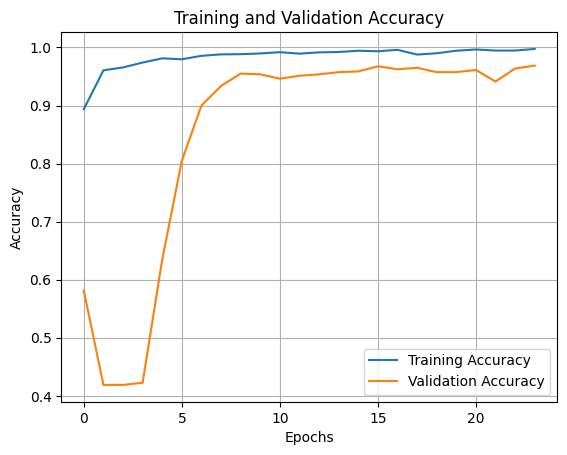

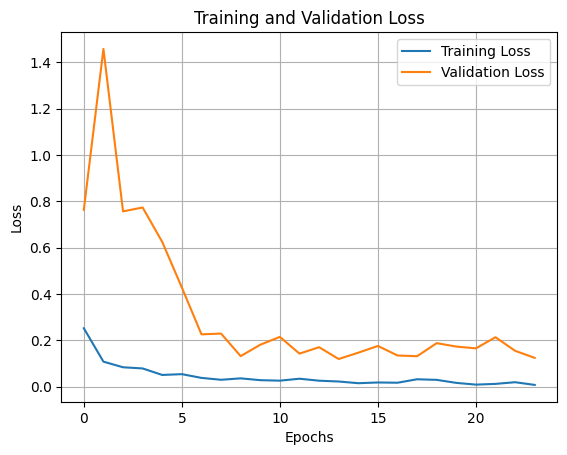

In [ ]:
# Plot Model Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Model Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train,  label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

Class Indices: {'Female': 0, 'Male': 1}


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, target_names):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)

    # Add labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

25/25 [==============================] - 13s 501ms/step - loss: 0.1333 - accuracy: 0.9613
Train Accuracy: 99.56%
Validation Accuracy: 96.13%
25/25 [==============================] - 13s 487ms/step

Validation Classification Report:
              precision    recall  f1-score   support

      Female     0.9779    0.9527    0.9651       465
        Male     0.9366    0.9701    0.9531       335

    accuracy                         0.9600       800
   macro avg     0.9573    0.9614    0.9591       800
weighted avg     0.9606    0.9600    0.9601       800


Validation Confusion Matrix:
[[443  22]
 [ 10 325]]

Validation Confusion Matrix (Plot):


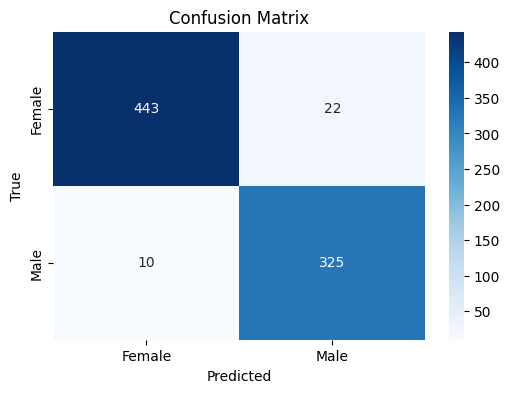

In [ ]:
# Model evaluation
scores_train = model.evaluate(train_generator, verbose=1)
scores_validation = model.evaluate(validation_generator, verbose=1)
print("Train Accuracy: %.2f%%" % (scores_train[1] * 100))
print("Validation Accuracy: %.2f%%" % (scores_validation[1] * 100))

# Class mapping
class_mapping = {0: 'Female', 1: 'Male'}
target_names=['Female', 'Male']

# Generate predictions for the validation set and convert the numeric predictions to class labels using the mapping
val_preds = model.predict(validation_generator)
val_preds = [class_mapping[int(round(pred[0]))] for pred in val_preds]

# Extract the true labels from the generator and convert the numeric labels to class labels using the mapping
val_labels = validation_generator.classes
val_labels = [class_mapping[label] for label in val_labels]

# Calculate the confusion matrix and classification report for validation
validation_confusion = confusion_matrix(val_labels, val_preds)
validation_report = classification_report(val_labels, val_preds, target_names=target_names, digits=4)

print("\nValidation Classification Report:")
print(validation_report)

print("\nValidation Confusion Matrix:")
print(validation_confusion)

print("\nValidation Confusion Matrix (Plot):")
plot_confusion_matrix(validation_confusion, target_names)


Testing

32/32 [==============================] - 4s 109ms/step

Test Classification Report:
              precision    recall  f1-score   support

      Female     0.9778    0.9695    0.9737       591
        Male     0.9565    0.9682    0.9623       409

    accuracy                         0.9690      1000
   macro avg     0.9672    0.9689    0.9680      1000
weighted avg     0.9691    0.9690    0.9690      1000


Test Confusion Matrix:
[[573  18]
 [ 13 396]]

Test Confusion Matrix (Plot):


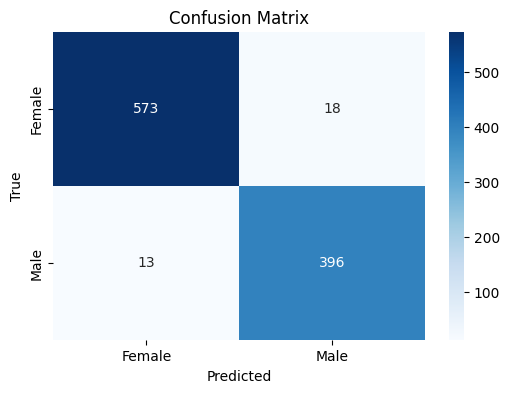

In [ ]:
from keras.models import load_model

# Load the trained model from the .h5 file
model = load_model('/content/gender_resnet50.h5')

# Generate predictions for the test set and convert the numeric predictions to class labels using the mapping
test_preds = model.predict(test_generator)
test_preds = [class_mapping[int(round(pred[0]))] for pred in test_preds]

# Extract the true labels from the generator and convert the numeric labels to class labels using the mapping
test_labels = test_generator.classes
test_labels = [class_mapping[label] for label in test_labels]

# Calculate the confusion matrix and classification report for the test set
test_confusion = confusion_matrix(test_labels, test_preds)
test_report = classification_report(test_labels, test_preds, target_names=target_names, digits=4)

print("\nTest Classification Report:")
print(test_report)

print("\nTest Confusion Matrix:")
print(test_confusion)

print("\nTest Confusion Matrix (Plot):")
plot_confusion_matrix(test_confusion, target_names)